In [2]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.kernels import MGGP_NSF_RBF
from gpzoo.gp import MGGP_NSF
import squidpy as sq
import numpy as np

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
new_model=False

In [5]:
adata = sq.datasets.slideseqv2()
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
Y = np.array(adata.raw.X[:, Y_sums>1000].todense() * 1000, dtype=int).T

In [5]:
X = adata.obsm['spatial']

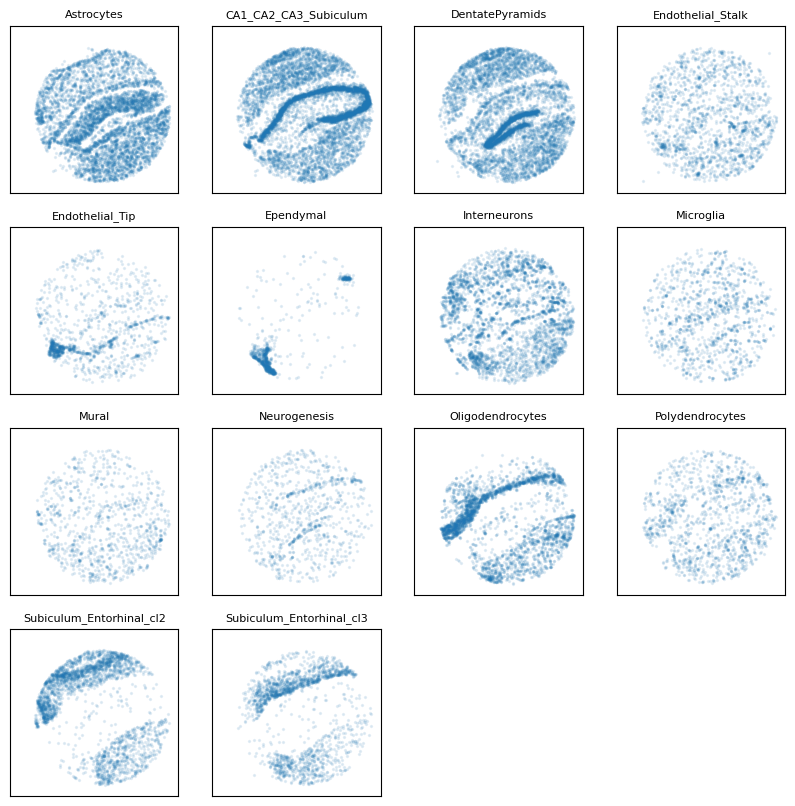

In [6]:
plt.figure(figsize=(10, 10))
for i, category in enumerate(adata.obs.cluster.values.categories):
    mask = adata.obs.cluster.values==category
    plt.subplot(4, 4, i+1)
    plt.title(category, fontsize=8)
    plt.scatter(adata.obs.x[mask], adata.obs.y[mask], alpha=0.1, s=2)
    plt.xlim([0, 6000])
    plt.ylim([0, 6000])
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])

In [7]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [8]:
L =10
M = 32*32
kernel = NSF_RBF(L=L, lengthscale=10)
model = NSF(X=X, y=Y, kernel=kernel, M=M, L=L, jitter=1e-2)
idz = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
model.svgp.Z = nn.Parameter(X[idz])

if not new_model:
    
    model.load_state_dict(torch.load('slideseq_nsf', map_location=device))
    print('Model loaded')
    
model.to(device)

Model loaded


NSF(
  (kernel): NSF_RBF()
  (svgp): SVGP(
    (kernel): NSF_RBF()
  )
)

In [9]:
def train(model: NSF, optimizer, X, y, steps=200, E=20, batched=False, batch_size=10):
    losses = []

    
    
    for it in tqdm(range(steps)):

        if batched:
            idys = torch.multinomial(torch.ones(Y.shape[0]), num_samples=Y.shape[0], replacement=False)
            batches = torch.split(idys, batch_size)

            for it, idy in tqdm(enumerate(batches)):
                optimizer.zero_grad()
                pY, _, qU, pU = model.batched_forward(X, idy, E=E)
                ELBO = (pY.log_prob(y[idy])).mean(axis=0).sum()
                ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
                loss = -ELBO
                loss.backward()
                optimizer.step()


        else:
        
            optimizer.zero_grad()
            pY, _, qU, pU = model(X, E=E)
            ELBO = (pY.log_prob(y)).mean(axis=0).sum()
            ELBO -= torch.sum(distributions.kl_divergence(qU, pU))


            loss = -ELBO
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())

        with torch.no_grad():
            if device.type=='cuda':
                torch.cuda.empty_cache()
        
    return losses

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:

X_train = X.to(device)
Y_train = Y.to(device)

In [ ]:
losses = train(model, optimizer, X_train, Y_train, steps=3000, E=1)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses)

In [ ]:
_, qF, _, _ = model(X_train, E=1)
loadings = torch.exp(qF.mean).detach().cpu().numpy()
del qF
with torch.no_grad():
    if device.type=='cuda':
        torch.cuda.empty_cache()

In [ ]:
max_val = np.percentile(loadings, 99)
min_val = np.percentile(loadings, 1)


size = 6
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[:, 0], X[:,1], c=loadings[i], vmin=min_val, vmax=max_val, alpha=0.9, s=2,  cmap='turbo')

    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])

In [ ]:
torch.save(model.state_dict(), 'slideseq_nsf') 